In [3]:
from pprint import pprint

print("""
Реализация нейронной сети на базе LSTM для решение задачи анализа настроения текста.
Набор данных - сообщения твиттора
Задача бинарной классификации
Стек: Keras, Tenserflow


""")



Реализация нейронной сети на базе LSTM для решение задачи анализа настроения текста.
Набор данных - сообщения твиттора
Задача бинарной классификации
Стек: Keras, Tenserflow





In [24]:
# ! pip install -r requirements.txt
%matplotlib notebook
from twitter_preproc import *
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard
import gensim
import time
from sklearn.model_selection import train_test_split
import tensorflow
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt


In [25]:
# WORD2VEC
W2V_SIZE = 200
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 200
EPOCHS = 8
BATCH_SIZE = 1024
DATASET_COLUMNS = ["target", "text"]

dataset_path = 'datasets/twitter_train_big.csv'

DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.7

In [ ]:
def labelTransform(l):
    if l == 4:
        return 1
    else:
        return 0
df = pd.read_csv(dataset_path, encoding=DATASET_ENCODING, names=DATASET_COLUMNS)
print('len of data: ')
print(len(df))

print(df.head(5))

df.target = df.target.apply(lambda x: labelTransform(x))
df.text = df.text.apply(lambda x: preprocess(x))

df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)

print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Распределени меток в датасете")
plt.show()

In [ ]:
documents = [_text.split() for _text in df_train.text]

w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE,
                                            window=W2V_WINDOW,
                                            min_count=W2V_MIN_COUNT,
                                            workers=8)
w2v_model.build_vocab(documents)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

In [ ]:
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)
y_train = np.array(df_train.target.tolist())
y_test = np.array(df_test.target.tolist())


print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)


In [ ]:
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)
y_train = np.array(df_train.target.tolist())
y_test = np.array(df_test.target.tolist())


print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)


In [ ]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)
embedding_layer = Embedding(vocab_size, W2V_SIZE,
                            weights=[embedding_matrix],
                            input_length=SEQUENCE_LENGTH,
                            trainable=False)

model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])
model.summary()


In [ ]:
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0,
                          write_graph=True, write_images=False)
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5),
              tensorboard]

history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)


model.save('twi_lstm.h5')
w2v_model.save('w2v.w2v')

In [ ]:
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:", score[1])
print("LOSS:", score[0])


In [ ]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = 0 if score < 0.5 else 1

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}


print(predict("I love the music"))
print(predict("I hate the rain"))


In [ ]:
print("""
Реализация нейронной сети на базе CNN для решение задачи классификации рукописных цифр
Набор данных - mnist
Задача многоклассовой классификации
Стек: Keras, Tenserflow


""")

In [11]:
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from keras import models
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard

In [12]:
(train_data, train_labels), (test_data, test_labels) = mnist.load_data()


train_data = train_data.reshape((60000, 28, 28, 1))
train_data = train_data.astype('float32') / 255

test_data = test_data.reshape((10000, 28, 28, 1))
test_data = test_data.astype('float32') / 255

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)


In [13]:

model = models.Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
tensorboard = TensorBoard(log_dir='./logs/cnn', histogram_freq=0,
                          write_graph=True, write_images=False)
print(model.summary())


Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0         
_________________________________________________________________
dens

In [ ]:
EPOCHS = 30
BATCH_SIZE = 64
history = model.fit(train_data, train_labels,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    verbose=1,
                    callbacks=[tensorboard, EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=8)])

score = model.evaluate(test_data, test_labels, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

model.save('mnist_cnn')

In [ ]:
print("""
Реализация отобора признаков на базе алгоритма рекурсивного исключения признаков


""")

In [19]:
from sklearn.datasets import load_breast_cancer
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.metrics import accuracy_score
import warnings
import numpy as np
warnings.filterwarnings('ignore')

/Users/user/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [20]:
data = load_breast_cancer()
x, y, f_name = data['data'], data['target'], data['feature_names']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

Optimal number of features : 26
Best features : ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean fractal dimension' 'radius error'
 'perimeter error' 'area error' 'compactness error' 'concavity error'
 'concave points error' 'fractal dimension error' 'worst radius'
 'worst texture' 'worst perimeter' 'worst area' 'worst smoothness'
 'worst compactness' 'worst concavity' 'worst concave points'
 'worst symmetry' 'worst fractal dimension']


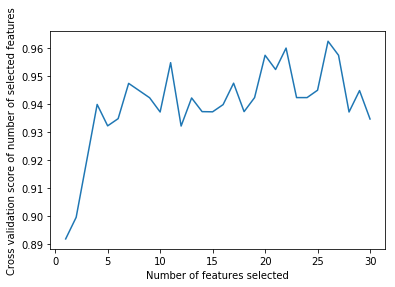

In [22]:
clf_rf = RandomForestClassifier()
rfecv = RFECV(estimator=clf_rf, step=1, cv=5,scoring='accuracy')   #5-fold cross-validation
rfecv = rfecv.fit(x_train, y_train)


print('Optimal number of features :', rfecv.n_features_)
print('Best features :', f_name[rfecv.support_])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score of number of selected features")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

Feature ranking:
1. feature 22 (0.289074)
2. feature 7 (0.203080)
3. feature 10 (0.087169)
4. feature 23 (0.067956)
5. feature 27 (0.067717)
6. feature 0 (0.060931)
7. feature 21 (0.034737)
8. feature 26 (0.023363)
9. feature 13 (0.019293)
10. feature 2 (0.018695)
11. feature 25 (0.013374)
12. feature 1 (0.011716)
13. feature 6 (0.010124)
14. feature 20 (0.009392)
15. feature 17 (0.009295)
16. feature 28 (0.009252)
17. feature 9 (0.008407)
18. feature 16 (0.007871)
19. feature 14 (0.006983)
20. feature 19 (0.006836)
21. feature 4 (0.006677)
22. feature 24 (0.005772)
23. feature 3 (0.005116)
24. feature 8 (0.003988)
25. feature 11 (0.003269)
26. feature 12 (0.002828)
27. feature 15 (0.002210)
28. feature 29 (0.001989)
29. feature 18 (0.001847)
30. feature 5 (0.001039)


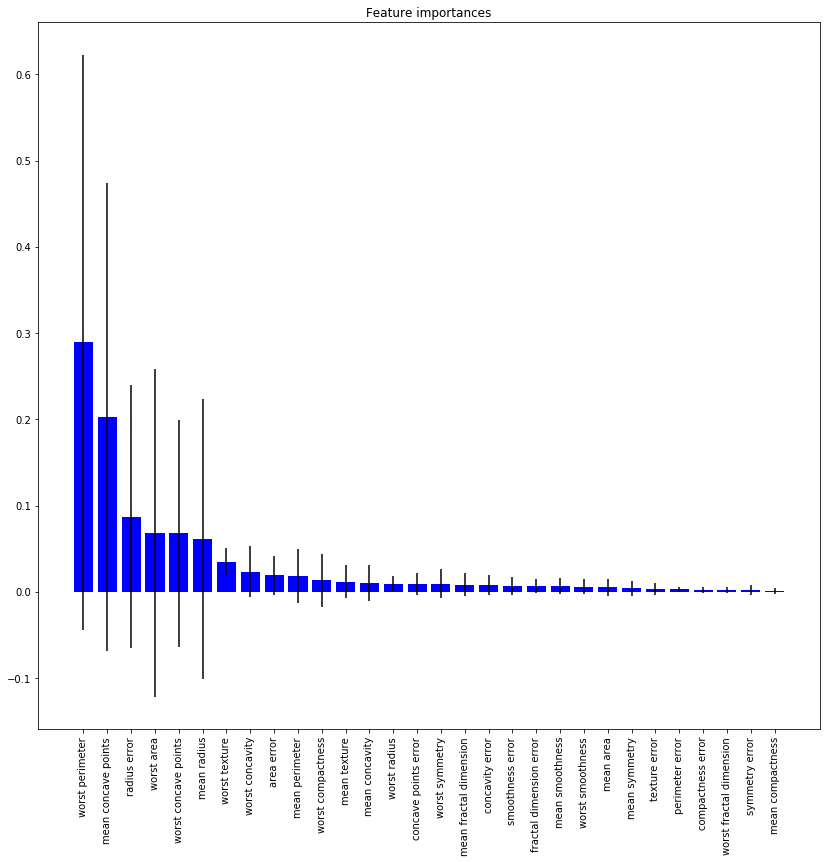

In [23]:

clf_rf = RandomForestClassifier()
clr_rf = clf_rf.fit(x_train,y_train)
importances = clr_rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf_rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(x_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))


plt.figure(1, figsize=(14, 13))
plt.title("Feature importances")
plt.bar(range(x_train.shape[1]), importances[indices],
       color="b", yerr=std[indices], align="center")
plt.xticks(range(x_train.shape[1]), f_name[indices],rotation=90)
# plt.xlim([-1, x_train.shape[1]])
plt.show()